In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
bike_data = pd.read_csv('bike.csv')

#bike_data.info()
bike_data.head()


,ID,PARK_AREA_ACRES,CTA_BUS_STATIONS,CTA_TRAIN_STATIONS,BIKE_ROUTES,Limited_Business_License,Retail_Food_Establishment,CAPACITY,PER_CAPITA_INCOME,POPULATION_SQ_MILE,...,PROSTITUTION,PUBLIC_INDECENCY,PUBLIC_PEACE_VIOLATION,ROBBERY,SEX_OFFENSE,STALKING,THEFT,WEAPONS_VIOLATION,trips,i
0,5,998.35328,217,19,37.260009,419417,118269,19,65526,36691.00331,...,2.397895,1.386294,4.369448,5.752573,3.951244,1.609438,8.269501,3.044522,10.092826,33
1,13,1204.28480,152,6,23.544022,42998,27496,19,65526,26901.43828,...,0.693147,0.000000,2.564949,4.905275,2.708050,1.098612,7.312553,0.693147,10.350798,33
2,14,1135.55648,133,2,21.615016,57119,23273,15,65526,27738.26651,...,1.609438,0.000000,2.639057,3.688879,1.098612,1.386294,6.089045,2.397895,9.227001,33
3,15,1108.60416,146,2,17.309916,31090,14369,15,88669,28008.49477,...,1.609438,0.000000,3.178054,3.891820,1.945910,1.386294,6.171701,2.944439,9.279493,33
4,16,955.64416,153,3,15.953728,43002,19727,11,65526,24577.70577,...,0.693147,0.000000,2.302585,5.351858,2.564949,0.000000,7.658700,2.397895,9.846441,33


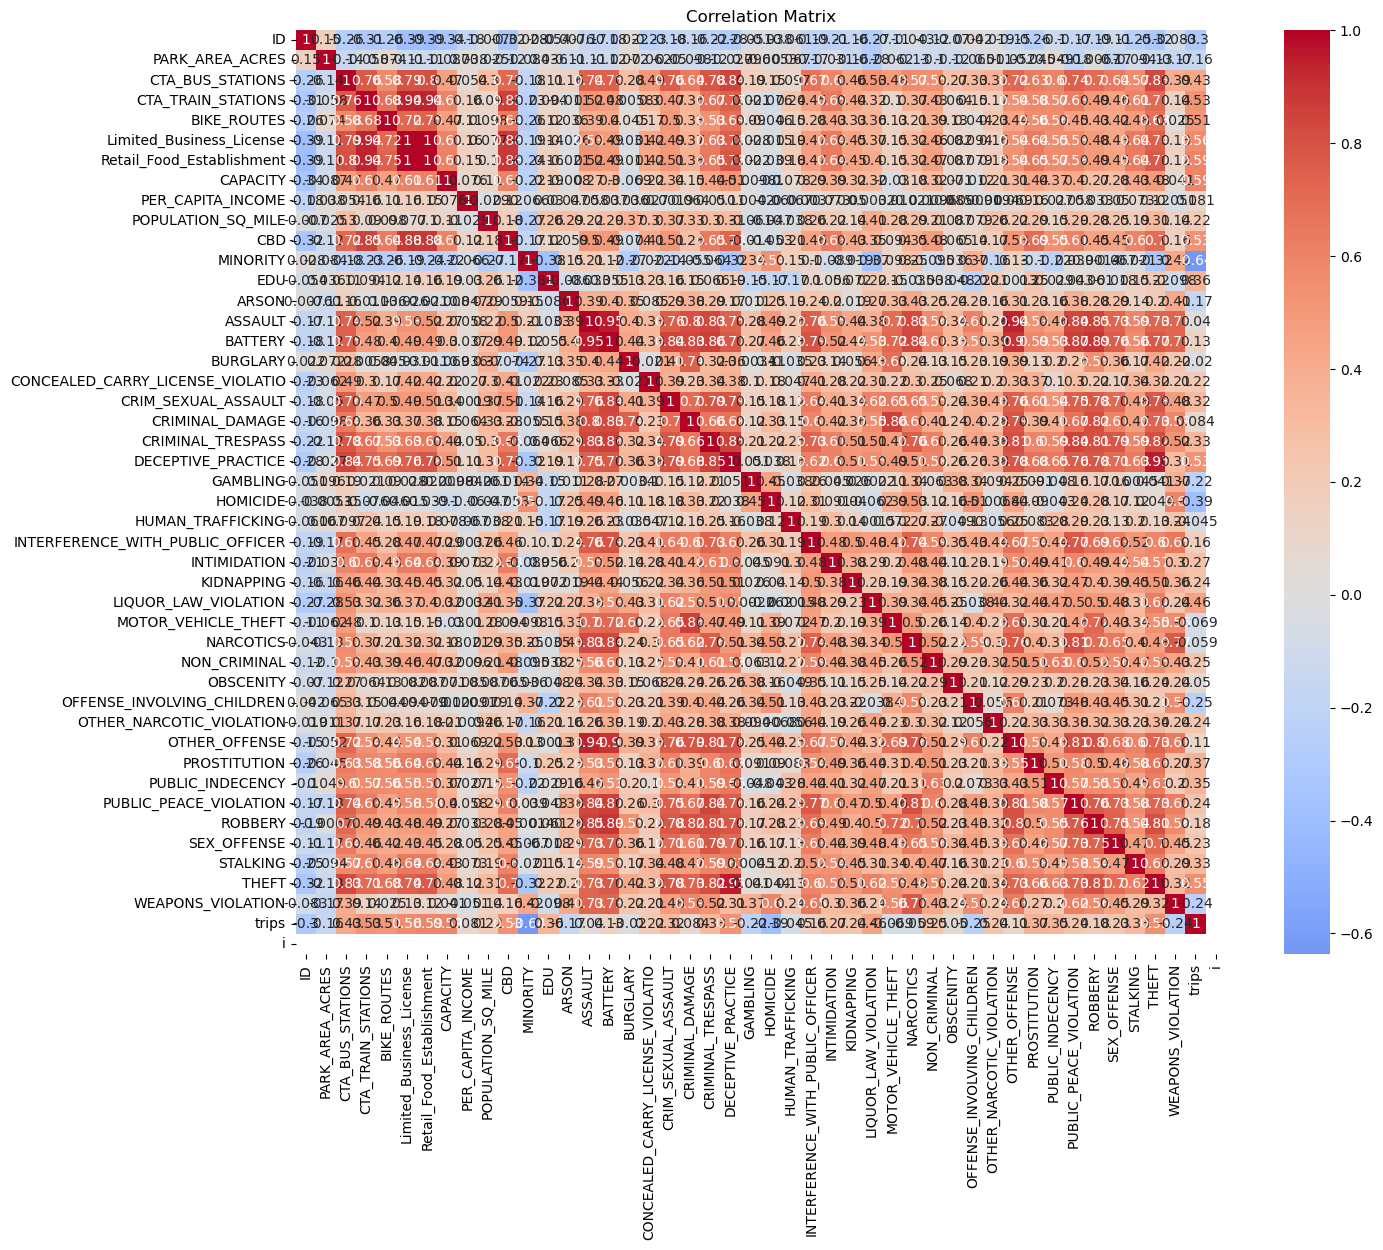

Correlations for trips                               1.000000
CAPACITY                            0.594428
Retail_Food_Establishment           0.593184
Limited_Business_License            0.560613
THEFT                               0.551326
DECEPTIVE_PRACTICE                  0.528705
CBD                                 0.526904
CTA_TRAIN_STATIONS                  0.526220
BIKE_ROUTES                         0.511121
LIQUOR_LAW_VIOLATION                0.461340
CTA_BUS_STATIONS                    0.430032
PROSTITUTION                        0.369083
EDU                                 0.358447
PUBLIC_INDECENCY                    0.350559
CRIMINAL_TRESPASS                   0.330410
STALKING                            0.329017
CRIM_SEXUAL_ASSAULT                 0.315757
INTIMIDATION                        0.267312
NON_CRIMINAL                        0.251042
PUBLIC_PEACE_VIOLATION              0.241828
OTHER_NARCOTIC_VIOLATION            0.241255
KIDNAPPING                          0.

In [3]:
# Computing the correlation matrix
corr_matrix = bike_data.corr()

# heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0) 
plt.title("Correlation Matrix")
plt.show()

# If you want to display correlations with a specific variable (e.g., 'trips')
corr_with_trips = corr_matrix['trips'].sort_values(ascending=False)
print(f"Correlations for {corr_with_trips}:")

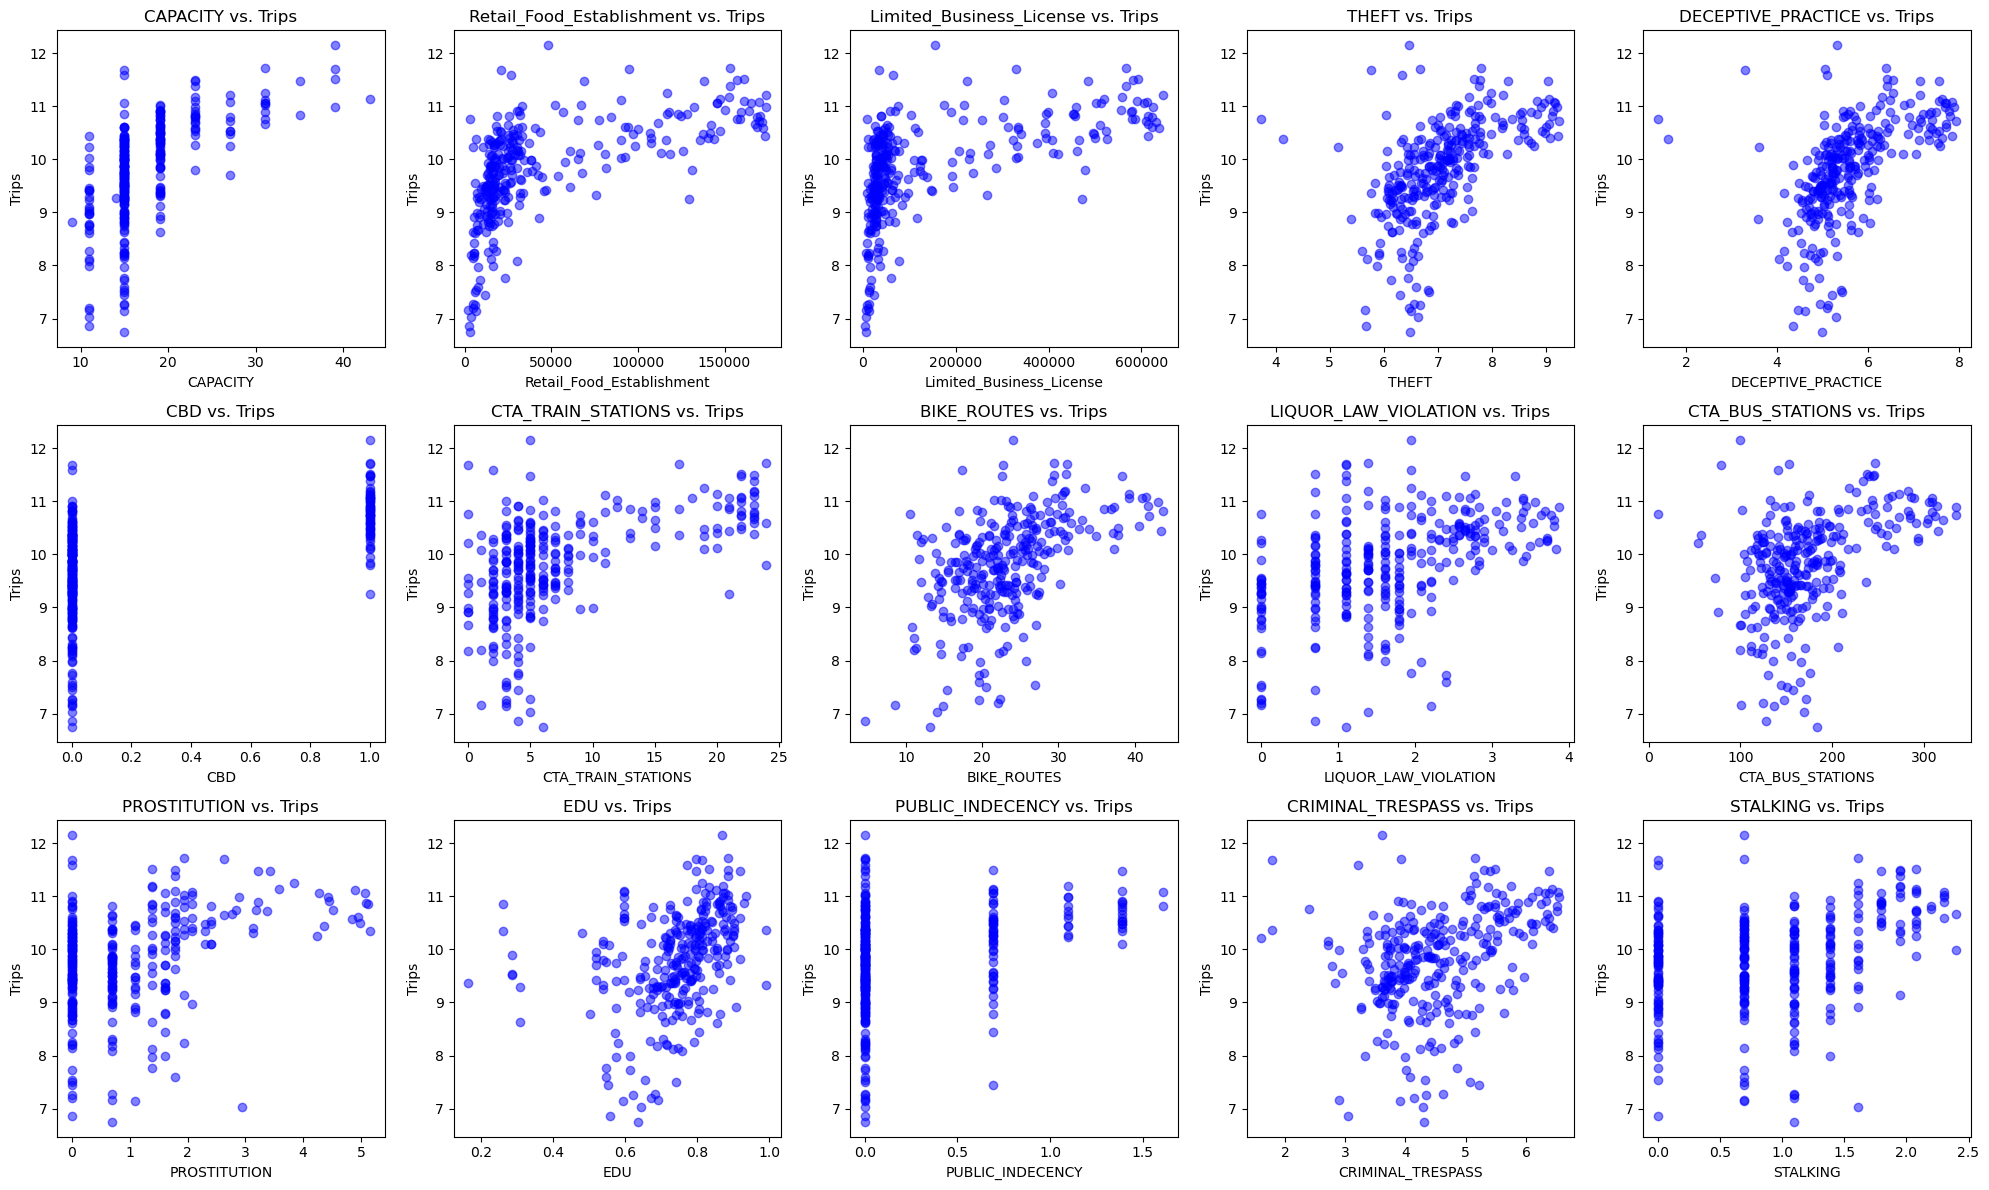

In [4]:
# Scatterplot for top 15
top_15_columns = [
    'CAPACITY', 'Retail_Food_Establishment', 'Limited_Business_License', 'THEFT',
    'DECEPTIVE_PRACTICE', 'CBD', 'CTA_TRAIN_STATIONS', 'BIKE_ROUTES', 
    'LIQUOR_LAW_VIOLATION', 'CTA_BUS_STATIONS', 'PROSTITUTION', 'EDU', 
    'PUBLIC_INDECENCY', 'CRIMINAL_TRESPASS', 'STALKING'
]

fig, axes = plt.subplots(3, 5, figsize=(20, 12))  

for i, column in enumerate(top_15_columns):
    row = i // 5  
    col = i % 5  
    
    axes[row, col].scatter(bike_data[column], bike_data['trips'], alpha=0.5, color='b')
    axes[row, col].set_title(f'{column} vs. Trips')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Trips')

plt.tight_layout()
plt.show()


### VIFs

In [5]:
# excluding the target variable 
#X = bike_data.drop(columns=['trips', 'ID'])
#Drop the high VIF variables
# X_reduced = X.drop(columns=['DECEPTIVE_PRACTICE', 'OTHER_OFFENSE'])

corr_with_trips = corr_matrix['trips'].abs().sort_values(ascending=False)
columns_to_drop = corr_with_trips[corr_with_trips < 0.0505].index.tolist()
columns_to_drop = ['trips', 'ID'] + columns_to_drop
X_reduced = bike_data.drop(columns=columns_to_drop)


# Update composite variables based on the columns that are still available

# Violent Crimes composite variable (excluding columns that were dropped)
X_reduced['Violent_Crimes'] = X_reduced[['BATTERY', 'WEAPONS_VIOLATION', 'HOMICIDE']].mean(axis=1)
X_reduced['Stealing_Related_Crimes'] = X_reduced[['DECEPTIVE_PRACTICE', 'THEFT', 'ROBBERY', 'GAMBLING', 'KIDNAPPING']].mean(axis=1)
X_reduced['Property_Crimes'] = X_reduced[['CRIMINAL_DAMAGE', 'MOTOR_VEHICLE_THEFT', 'ARSON']].mean(axis=1)
X_reduced['Public_Order_Crimes'] = X_reduced[['PUBLIC_PEACE_VIOLATION', 'LIQUOR_LAW_VIOLATION', 'PUBLIC_INDECENCY']].mean(axis=1)
#X_reduced['Drug_Related_Crimes'] = X_reduced[['NARCOTICS', 'OTHER_NARCOTIC_VIOLATION']].mean(axis=1)
X_reduced['Transit_Access'] = X_reduced[['CTA_TRAIN_STATIONS', 'CTA_BUS_STATIONS']].mean(axis=1)
X_reduced['Recreational_Access'] = X_reduced[['BIKE_ROUTES', 'PARK_AREA_ACRES']].mean(axis=1)
X_reduced['Socioeconomic_Status'] = X_reduced[['EDU', 'POPULATION_SQ_MILE', 'PER_CAPITA_INCOME']].mean(axis=1)
X_reduced['CBD_Indicator'] = X_reduced[['Retail_Food_Establishment', 'Limited_Business_License', 'CTA_TRAIN_STATIONS', 'CTA_BUS_STATIONS']].mean(axis=1)
X_reduced['Sexual_Crimes'] = X_reduced[['CRIM_SEXUAL_ASSAULT', 'SEX_OFFENSE', 'PROSTITUTION', 'STALKING']].mean(axis=1)

# Drop original columns used to create the updated composite variables
X_reduced = X_reduced.drop(columns=['BATTERY', 'WEAPONS_VIOLATION', 'ROBBERY','ARSON',
                                    'THEFT', 'CRIMINAL_DAMAGE', 'PUBLIC_PEACE_VIOLATION',
                                    'LIQUOR_LAW_VIOLATION', 'PUBLIC_INDECENCY', 'NARCOTICS',
                                    'OTHER_NARCOTIC_VIOLATION', 'CTA_TRAIN_STATIONS',
                                    'CTA_BUS_STATIONS', 'BIKE_ROUTES', 'PARK_AREA_ACRES','KIDNAPPING',
                                    'EDU', 'POPULATION_SQ_MILE', 'PER_CAPITA_INCOME','GAMBLING',
                                    'Retail_Food_Establishment', 'Limited_Business_License', 
                                    'MOTOR_VEHICLE_THEFT', 'DECEPTIVE_PRACTICE', 'NARCOTICS', 'OTHER_NARCOTIC_VIOLATION',
                                    'OTHER_OFFENSE', 'HOMICIDE', 'CRIM_SEXUAL_ASSAULT', 'SEX_OFFENSE', 'PROSTITUTION', 'STALKING'
                                    ])

# Calculate VIF for the updated DataFrame
X_reduced_with_const = add_constant(X_reduced)
vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = X_reduced_with_const.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced_with_const.values, i) for i in range(X_reduced_with_const.shape[1])]
vif_data_reduced = vif_data_reduced.sort_values(by="VIF", ascending=False).reset_index(drop=True)

print(vif_data_reduced)


                             Feature         VIF
0                                  i  227.577455
1            Stealing_Related_Crimes    8.574334
2                      CBD_Indicator    8.400515
3                     Transit_Access    7.499946
4                  CRIMINAL_TRESPASS    6.378989
5                      Sexual_Crimes    6.080378
6                                CBD    5.846477
7                Public_Order_Crimes    5.355473
8                     Violent_Crimes    5.055442
9   INTERFERENCE_WITH_PUBLIC_OFFICER    3.472698
10                   Property_Crimes    3.151946
11                          MINORITY    2.255736
12        OFFENSE_INVOLVING_CHILDREN    2.073695
13                      INTIMIDATION    2.055401
14                      NON_CRIMINAL    2.025765
15                          CAPACITY    1.772940
16  CONCEALED_CARRY_LICENSE_VIOLATIO    1.482042
17              Socioeconomic_Status    1.187770
18               Recreational_Access    1.145695


### Model: OLS

In [6]:
#Fit the OLS model 
X_reduced = X_reduced.drop(columns=['i'])
X_reduced_with_const = add_constant(X_reduced) # so it doesn't go through origin
y = bike_data['trips']  

model = sm.OLS(y, X_reduced_with_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  trips   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     43.54
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.24e-70
Time:                        16:35:01   Log-Likelihood:                -212.98
No. Observations:                 300   AIC:                             464.0
Df Residuals:                     281   BIC:                             534.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [7]:

# testing robustness
import statsmodels.api as sm

# Removing one variable, e.g., 'CBD', from the reduced dataset
X_test = X_reduced.drop(columns=['CBD'])

# Adding a constant for the OLS model
X_test_with_const = sm.add_constant(X_test)

# Fitting the OLS model with the modified dataset
model_test = sm.OLS(y, X_test_with_const).fit()

# Displaying the summary of the new model
print(model_test.summary())

                            OLS Regression Results                            
Dep. Variable:                  trips   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     46.21
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           3.59e-71
Time:                        16:35:01   Log-Likelihood:                -213.09
No. Observations:                 300   AIC:                             462.2
Df Residuals:                     282   BIC:                             528.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   


#### Why some crimes should be positively associated with trips:
Property and Public Order Crimes 
- THEFT and DECEPTIVE_PRACTICE and other similar crimes are common in areas with dense population, businesses, and high economic activity, such as Central Business Districts (CBDs), and naturally see more bike trips due to higher traffic from tourists, etc. These crime rates in such areas don't deter bike usage but, they reflect high activity levels. People also don't think of death for these crimes so they don't feel as unsafe to bike.

- Public Order Crimes (Liquor Law Violation and Public Peace Violation) also should correlate positively. These might occur in lively districts (clubbing and gaming type areas) where there are both high foot traffic and Divvy stations.

Criminal Trespass, Prostitution, and Sex-Related Crimes (moderately positive):
- Areas with CRIMINAL TRESPASS, PROSTITUTION, etc might also reflect higher activity in areas with high pedestrian and cycling traffic. These areas may serve as commuting hubs, and even if they have minor crimes, they still attract cyclists.

#### Why others would be negatively associated:
Violent Crimes ('BATTERY', 'WEAPONS_VIOLATION', 'HOMICIDE'):
- Areas with high violent crime rates tend to deter people from using public modes of transportation, including bike sharing because they may feel unsafe, discouraging cycling activity. 

Property Crimes like Arson and Burglary:
- These crimes likely occur in areas that are more residential, where biking infrastructure and public transport use are less prevalent, thus showing a negative correlation.

#### Why some should not affect trips at all: 
Assault and Battery:
- Crimes like ASSAULT and BATTERY may not significantly impact bike demand, since they are widespread across different neighborhoods, and may not directly influence commuter behavior unless crime levels are extreme.
- Non-criminal Violations:
These tend to have a weaker correlation, since they may not occur in locations directly influencing Divvy bike usage.

#### Composite Crime Variables
Violent Crimes (e.g., BATTERY, ASSAULT, HOMICIDE) 
- expected to discourage bike trips due to safety concerns

Property Crimes (e.g., THEFT, BURGLARY, ARSON) 
- positively correlate because they occur in high-density areas with more trips

Public Order Crimes(PUBLIC PEACE VIOLATION, LIQUOR LAW VIOLATION, PUBLIC INDECENCY)
- might reflect nightlife leading to increased demand for bikes

Stealing-Related Crimes (DECEPTIVE PRACTICE, THEFT, ROBBERY, GAMBLING, KIDNAPPING)
- related to theft and deception. these crimes often occur in busy commercial or high-activity areas where bike use is common.

Transit Access (CTA TRAIN STATIONS, CTA BUS STATIONS)
- Higher transit access is expected to positively correlate with Divvy trips, as people can use bikes as a "last mile" option to connect with bus or train services.

Recreational Access (BIKE ROUTES, PARK AREA ACRES)
- for proximity to recreational infrastructure like bike routes and parks. The relationship might be negative if the area is more relaxed, infrequent trips as opposed to high-volume commuter trips.

Socioeconomic Status (EDU, POPULATION DENSITY, PER CAPITA INCOME)
- This variable captures economic and demographic factors, combining education level, population density, and income. Its impact on Divvy trips is expected to vary depending on the specific area, with wealthier and denser neighborhoods possibly seeing more trips.

CBD Indicator (RETAIL FOOD ESTABLISHMENT, LIMITED BUSINESS LICENSE, CTA TRAIN STATIONS, CTA BUS STATIONS)
- This variable identifies whether a station is located in or near a central business district (CBD). Stations in CBDs are expected to experience higher demand for Divvy trips due to increased commercial activity and access to public transportation.

Sexual Crimes (CRIMINAL SEXUAL ASSAULT, SEX OFFENSE, PROSTITUTION, STALKING)
- people may avoid biking in areas with higher rates of sexual offenses due to safety concerns.



## Written Summary
- The model explains a significant portion of the variation in Divvy trips, with an R-squared of 0.736, suggesting it captures approximately 74% of the variability in demand. The F-stat is significant (p-value = 1.45e-69), indicating that at least some of the predictors are strongly related to trips.

Key Variables and Their Impacts:

- Capacity: (0.0474, p < 0.001): stations with higher capacity tend to experience more trips. This is expected, as larger stations can accommodate more users.

- Minority: (-1.5907, p < 0.001) suggests that Divvy usage is less frequent in areas with higher minority populations, potentially reflecting unequal access to the service

- Stealing Related Crimes:(coef = 0.3542, p = 0.024), indicates that areas with higher incidents of theft-related crimes tend to see Divvy usage. One potential reason could be that these areas also have more urban activity and thus more bike usage overall? 

- Property Crimes:(-0.4255, p < 0.001) suggests that areas with higher rates of property crimes see fewer Divvy trips. This could be due to safety concerns.

- Recreational Access: This variable is slightly negatively correlated with trips (-0.0018, p < 0.001), which might reflect that stations near recreational areas may not cater to the commuting needs of Divvy users.

- CBD_Indicator: (3.631e-06, p = 0.014) shows that stations located in or near CBDs see higher usage, supporting the idea that Divvy is popular in areas with high business density and urban activity.

Insignificant Variables:

Violent Crimes, Drug-Related Crimes, and Sexual Crimes, did not show a significant relationship with Divvy trips, indicating these crimes may not directly influence bike-sharing usage.
Socioeconomic Status was also insignificant, which might suggest that other variables in the model capture socioeconomic effects more effectively.

Robustness and Model Considerations:

The model seems robust overall, but small changes in  certain crime categories or composite variables do not drastically alter the conclusions. Some insignificant variables may still hold value for interpreting broader urban dynamics even if they do not strongly predict Divvy usage. The model's results align with expected behavior in urban mobility, showing how infrastructure, safety, and social factors interact to affect bike-sharing demand.
